In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
should_skip = True

In [3]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq accelerate transformers ftfy
  !pip install -q gpustat gdown
  !pip install -q pytorch_lightning

In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

In [6]:
# %cd /content/
# sys.path.append("/content/slime-experiments/")

In [7]:
# !rm -rf slime-experiments/
# !git clone https://github.com/andrew-healey/slime-experiments
# !cd slime-experiments && git rev-parse --short HEAD

In [8]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule

In [28]:
train_dataset = BinarySegmentationDataset(
    data_root="my_concept",
    mask_root="my_concept_gt",
)
test_dataset = BinarySegmentationDataset(
    data_root="my_concept_test",
    mask_root=None
)

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=500,
    batch_size=1,
)

In [29]:
slime = SLiME(
    use_self_attn=False,
    alpha=1.0,
    gamma=1.0,
    multiplier_lr=0.05,
    cross_attn_nums=[8]
).cuda()

In [30]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=1,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 32    
2 | self_layer_multiplier  | Multiplier      | 32    
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_multiplier    | Multiplier      | 4     
5 | cross_norm             | BatchNorm2d     | 2     
6 | cross_map_norm         | BatchNorm2d     | 4     
  | other params           | n/a             | 2.0 K 
-----------------------------------------------------------
2.1 K     Trainable params
900 M     Non-trainable params
900 M     Total params
3,600.306 Total esti

Training: |          | 0/? [00:00<?, ?it/s]

pred -4.17 3.04 ce loss 0.85 mse loss 0.32 dice loss 0.68
pred -1.35 2.8 ce loss 0.54 mse loss 0.18 dice loss 0.45
pred -1.38 2.74 ce loss 0.52 mse loss 0.17 dice loss 0.44
pred -1.48 2.18 ce loss 0.51 mse loss 0.16 dice loss 0.5
pred -1.71 2.59 ce loss 0.49 mse loss 0.16 dice loss 0.43
pred -1.89 2.03 ce loss 0.49 mse loss 0.16 dice loss 0.49
pred -1.83 2.22 ce loss 0.47 mse loss 0.15 dice loss 0.48
pred -1.79 2.69 ce loss 0.46 mse loss 0.15 dice loss 0.42
pred -2.0 2.25 ce loss 0.45 mse loss 0.14 dice loss 0.47
pred -2.03 2.5 ce loss 0.43 mse loss 0.13 dice loss 0.4
pred -2.21 2.7 ce loss 0.44 mse loss 0.14 dice loss 0.4
pred -2.23 2.49 ce loss 0.43 mse loss 0.13 dice loss 0.46
pred -2.64 2.69 ce loss 0.43 mse loss 0.13 dice loss 0.39
pred -2.35 2.75 ce loss 0.41 mse loss 0.13 dice loss 0.44
pred -2.56 2.85 ce loss 0.4 mse loss 0.12 dice loss 0.43
pred -2.76 2.98 ce loss 0.39 mse loss 0.12 dice loss 0.37
pred -3.09 3.07 ce loss 0.39 mse loss 0.12 dice loss 0.37
pred -2.82 2.72 ce los

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [31]:
slime.cuda(); 0

0

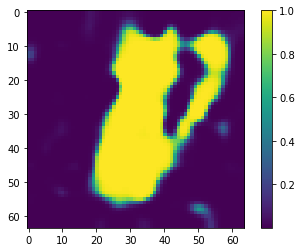

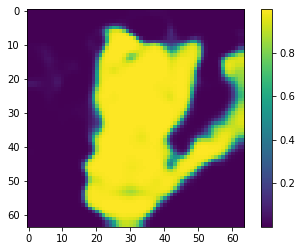

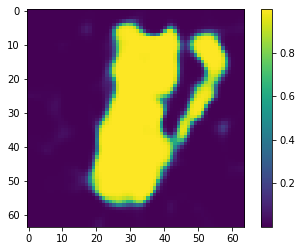

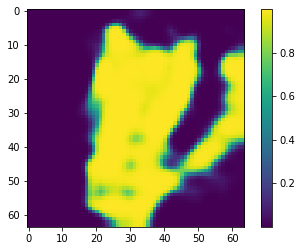

In [32]:
import matplotlib.pyplot as plt
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
for i in range(4):
    a = sigmoid(slime.latest_preds[-1-i].swapaxes(1,2).reshape((-1,slime.text_tokens,64,64))[0,1])
    plt.imshow(a)
    plt.colorbar()
    plt.show()

In [33]:
#@title Infer on test set
out_mask = None
loader = data_module.test_dataloader()
out_masks=[]
for i,batch in enumerate(loader):
  out_mask = slime.predict_step(batch,i).cpu().numpy()
  out_masks.append(out_mask)

import matplotlib.pyplot as plt
for out_mask in out_masks:
  for j in range(len(out_mask)):
    plt.imshow(sigmoid(out_mask[j,:,1].reshape((64,64))))
    plt.colorbar()
    plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 320.00 MiB. GPU 0 has a total capacty of 11.76 GiB of which 281.75 MiB is free. Process 425892 has 11.35 GiB memory in use. Of the allocated memory 10.90 GiB is allocated by PyTorch, and 299.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

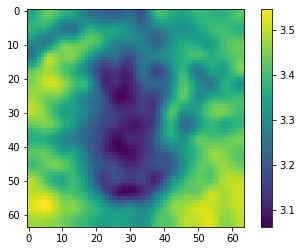

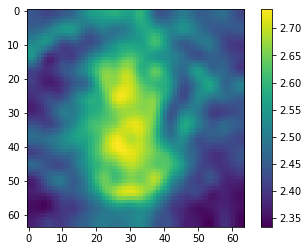

tensor([0.7261, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753,
        0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753],
       device='cuda:0')


In [ ]:
preds = slime.latest_means
# print([(pred.shape,pred.mean(axis=1)) for pred in preds])

for pred in preds:
    for i in range(pred.shape[1]):
        plt.imshow(pred[0,i].reshape((64,64)))
        plt.colorbar()
        plt.show()

print(slime.cross_layer_multiplier.weight.data)

[(20, 256, 4)]
Layer 0


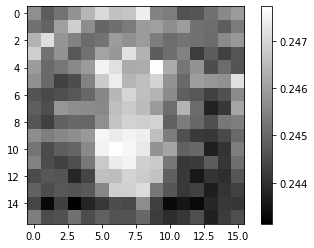

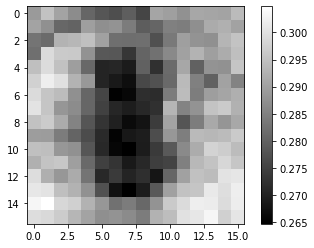

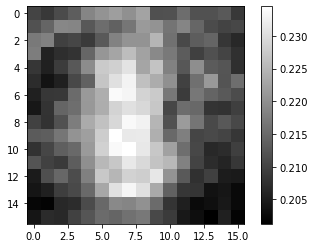

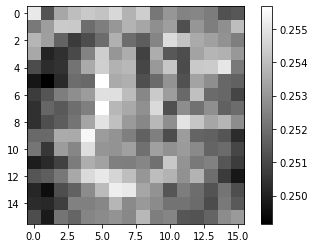

tensor([0.7261, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753,
        0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753, 0.9753],
       device='cuda:0')


In [ ]:
xattns = slime.latest_xattns
print([(xattn.shape) for xattn in xattns])

for i,xattn in enumerate(xattns):
    print("Layer",i)
    img_tokens = xattn.shape[1]
    img_dim = int(math.sqrt(img_tokens))
    reshaped = xattn.mean(axis=0,keepdims=True).reshape((img_dim,img_dim,-1))
    for j in range(reshaped.shape[-1]):
        plt.imshow(reshaped[...,j],cmap="gray")
        plt.colorbar()
        plt.show()

print(slime.cross_layer_multiplier.weight.data)

In [ ]:
!cd /content/slime-experiments/ && git diff

/bin/bash: line 0: cd: /content/slime-experiments/: No such file or directory
